# Fine Tuning VGG16

<i>Tools: Keras, VGG16, numpy, matplotlib, pandas, PIL</i>

Here we will fine-tune a pretrained VGG16 model with ImageNet weights and retrain the last few layers to create a classifier that will predict 7 bag-type categories. 

Categories:
- 0 : backpacks
- 1 : buckets
- 2 : clutch
- 3 : circles
- 4 : fanny packs
- 5 : shoulder bags
- 6 : totes

Once this model is trained, we will extract features of each bag image from one of the newly trained layers and use a distance metric (cosine similarity, minkowski distance, or KNN) to find most similar bags in order to recommend ethical options that are most similar to an unethical option.



In [1]:
from keras import models
from keras import layers
from keras import optimizers
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.datasets import fashion_mnist
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [50]:
vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=(48, 48, 3))

In [51]:
# Freeze the layers except the last 4 layers
for layer in vgg_conv.layers[:-4]:
    layer.trainable = False
    
# Check the trainable status of the individual layers
for layer in vgg_conv.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0xb334145f8> False
<keras.layers.convolutional.Conv2D object at 0xb33414b38> False
<keras.layers.convolutional.Conv2D object at 0xb33414400> False
<keras.layers.pooling.MaxPooling2D object at 0xb3223ce48> False
<keras.layers.convolutional.Conv2D object at 0xb3223ca58> False
<keras.layers.convolutional.Conv2D object at 0xb301e1198> False
<keras.layers.pooling.MaxPooling2D object at 0xb3034b2b0> False
<keras.layers.convolutional.Conv2D object at 0xb3034b7f0> False
<keras.layers.convolutional.Conv2D object at 0xb3037d470> False
<keras.layers.convolutional.Conv2D object at 0xb30398358> False
<keras.layers.pooling.MaxPooling2D object at 0xb303b45c0> False
<keras.layers.convolutional.Conv2D object at 0xb303b4c88> False
<keras.layers.convolutional.Conv2D object at 0xb303e8cc0> False
<keras.layers.convolutional.Conv2D object at 0xb30402e80> False
<keras.layers.pooling.MaxPooling2D object at 0xb304348d0> False
<keras.layers.convolutional.Conv2D obj

In [52]:
# Create the model and start with vgg_conv base
model = models.Sequential()
model.add(vgg_conv)
 
# Add new layers
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(7, activation='softmax'))
 
# Show a summary of the model. Check the number of trainable parameters
model.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              525312    
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 3075      
Total params: 15,243,075
Trainable params: 7,607,811
Non-trainable params: 7,635,264
_________________________________________________________________


In [ ]:
train_dir = './bags'
validation_dir

In [ ]:
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
 
validation_datagen = ImageDataGenerator(rescale=1./255)
 
# Change the batchsize according to your system RAM
train_batchsize = 50
val_batchsize = 5
 
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(image_size, image_size),
        batch_size=train_batchsize,
        class_mode='categorical')
 
validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(image_size, image_size),
        batch_size=val_batchsize,
        class_mode='categorical',
        shuffle=False)

In [ ]:
# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])
# Train the model
history = model.fit_generator(
      train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size ,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples/validation_generator.batch_size,
      verbose=1)
 
# Save the model
model.save('small_last4.h5')

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [ ]:
# Create a generator for prediction
validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(image_size, image_size),
        batch_size=val_batchsize,
        class_mode='categorical',
        shuffle=False)
 
# Get the filenames from the generator
fnames = validation_generator.filenames
 
# Get the ground truth from generator
ground_truth = validation_generator.classes
 
# Get the label to class mapping from the generator
label2index = validation_generator.class_indices
 
# Getting the mapping from class index to class label
idx2label = dict((v,k) for k,v in label2index.items())
 
# Get the predictions from the model using the generator
predictions = model.predict_generator(validation_generator, steps=validation_generator.samples/validation_generator.batch_size,verbose=1)
predicted_classes = np.argmax(predictions,axis=1)
 
errors = np.where(predicted_classes != ground_truth)[0]
print("No of errors = {}/{}".format(len(errors),validation_generator.samples))
 
# Show the errors
for i in range(len(errors)):
    pred_class = np.argmax(predictions[errors[i]])
    pred_label = idx2label[pred_class]
     
    title = 'Original label:{}, Prediction :{}, confidence : {:.3f}'.format(
        fnames[errors[i]].split('/')[0],
        pred_label,
        predictions[errors[i]][pred_class])
     
    original = load_img('{}/{}'.format(validation_dir,fnames[errors[i]]))
    plt.figure(figsize=[7,7])
    plt.axis('off')
    plt.title(title)
    plt.imshow(original)
    plt.show()

In [47]:
x_train[0,:,:,:].shape

(48, 48, 3)

In [11]:
# load the fashion-mnist images, split into train and test set
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [12]:
num_classes = len(np.unique(y_train))
num_classes

10

In [13]:
print( f"Training size {x_train.shape}")
print( f"Test size {x_test.shape}")

Training size (60000, 28, 28)
Test size (10000, 28, 28)


Text(0.5, 1.0, 'Ground Truth : 9')

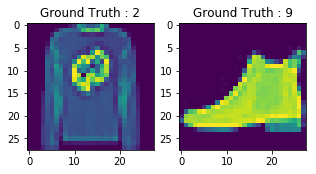

In [14]:
img_index = 123

plt.figure(figsize=[5,5])

# Display the first image in training data
plt.subplot(121)
plt.imshow(x_train[img_index])
plt.title("Ground Truth : {}".format(y_train[img_index]))

# Display the first image in testing data
plt.subplot(122)
plt.imshow(x_test[img_index])
plt.title("Ground Truth : {}".format(y_test[img_index]))

In [15]:
x_train=np.dstack([x_train] * 3)
x_test=np.dstack([x_test]*3)
x_train.shape, x_test.shape

((60000, 28, 84), (10000, 28, 84))

In [16]:
# Reshape images as per the tensor format required by tensorflow
x_train = x_train.reshape(-1, 28,28,3)
x_test= x_test.reshape (-1,28,28,3)
x_train.shape, x_test.shape

((60000, 28, 28, 3), (10000, 28, 28, 3))

In [17]:
# change datatype to float32 and resize so value falls between 0 and 1 by dividing by 255
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

In [18]:
# Resize the images 48*48 as required by VGG16
from keras.preprocessing.image import img_to_array, array_to_img

x_train = np.asarray([img_to_array(array_to_img(im, scale=False).resize((48,48))) for im in x_train])
x_test = np.asarray([img_to_array(array_to_img(im, scale=False).resize((48,48))) for im in x_test])
#train_x = preprocess_input(x)
x_train.shape, x_test.shape

((60000, 48, 48, 3), (10000, 48, 48, 3))

In [19]:
# Converting Labels to one hot encoded format
from keras.utils import to_categorical

y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

In [20]:
from sklearn.model_selection import train_test_split
# Splitting train data as train and validation data
XTrain,XValid,yTrain,yValid = train_test_split(x_train,y_train_one_hot,
                                                           test_size=0.2,
                                                           random_state=13
                                                           )

In [21]:
# Finally check the data size whether it is as per tensorflow and VGG16 requirement
XTrain.shape,XValid.shape,yTrain.shape,yValid.shape

((48000, 48, 48, 3), (12000, 48, 48, 3), (48000, 10), (12000, 10))

In [22]:
# Define the parameters for instanitaing VGG16 model. 
IMG_WIDTH = 48
IMG_HEIGHT = 48
IMG_DEPTH = 3
BATCH_SIZE = 16

In [23]:
XTrain = preprocess_input(XTrain)
XValid = preprocess_input(XValid)
x_test = preprocess_input(x_test)

In [25]:
vgg16_base = VGG16(weights='imagenet',
                  include_top=False, 
                  input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH)
                 )
vgg16_base.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 48, 48, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
_________________________________________________________________
bloc

In [29]:
# Extracting features
train_features = vgg16_base.predict(np.array(XTrain), batch_size=BATCH_SIZE, verbose=1)
test_features = vgg16_base.predict(np.array(x_test), batch_size=BATCH_SIZE, verbose=1)
val_features = vgg16_base.predict(np.array(XValid), batch_size=BATCH_SIZE, verbose=1)
#for layer in conv_base.layers:
#    layer.trainable = False

12000/12000 [==============================] - 195s 16ms/step


In [30]:
# 6.1 Saving the features so that they can be used for future
np.savez("train_features_VGG16fashionmnist", train_features, yTrain)
np.savez("test_features_VGG16fashionmnist", test_features, y_test)
np.savez("val_features_VGG16fashionmnist", val_features, yValid)

In [31]:
# Current shape of features
print(train_features.shape, "\n",  test_features.shape, "\n", val_features.shape)

(48000, 1, 1, 512) 
 (10000, 1, 1, 512) 
 (12000, 1, 1, 512)


In [32]:
# Flatten extracted features
train_features_flat = np.reshape(train_features, (48000, 1*1*512))
test_features_flat = np.reshape(test_features, (10000, 1*1*512))
val_features_flat = np.reshape(val_features, (12000, 1*1*512))

In [33]:
from keras import models
from keras.models import Model
from keras import layers
from keras import optimizers
from keras import callbacks
from keras.layers.advanced_activations import LeakyReLU

In [34]:
# 7.0 Define the densely connected classifier followed by leakyrelu layer and finally dense layer for the number of classes
NB_TRAIN_SAMPLES = train_features_flat.shape[0]
NB_VALIDATION_SAMPLES = val_features_flat.shape[0]
NB_EPOCHS = 100

model = models.Sequential()
model.add(layers.Dense(512, activation='relu', input_dim=(1*1*512)))
model.add(layers.LeakyReLU(alpha=0.1))
model.add(layers.Dense(num_classes, activation='softmax'))

In [35]:
# Compile the model.
model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.Adam(),
  # optimizer=optimizers.RMSprop(lr=2e-5),
    metrics=['acc'])

In [36]:
# Incorporating reduced learning and early stopping for callback
reduce_learning = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    verbose=1,
    mode='auto',
    epsilon=0.0001,
    cooldown=2,
    min_lr=0)

eary_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=7,
    verbose=1,
    mode='auto')

callbacks = [reduce_learning, eary_stopping]

/Users/gracejeong/anaconda3/lib/python3.7/site-packages/keras/callbacks.py:1065: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [38]:
# Train the the model
history = model.fit(
    train_features_flat,
    yTrain,
    epochs=NB_EPOCHS,
    validation_data=(val_features_flat, yValid),
    callbacks=callbacks
)

Instructions for updating:
Use tf.cast instead.
Train on 48000 samples, validate on 12000 samples
Epoch 1/100
48000/48000 [==============================] - 5s 104us/step - loss: 2.4183 - acc: 0.1164 - val_loss: 2.3906 - val_acc: 0.1139
Epoch 2/100
48000/48000 [==============================] - 5s 95us/step - loss: 2.3052 - acc: 0.1300 - val_loss: 2.2721 - val_acc: 0.1740
Epoch 3/100
48000/48000 [==============================] - 5s 96us/step - loss: 2.2693 - acc: 0.1381 - val_loss: 2.2622 - val_acc: 0.1143
Epoch 4/100
48000/48000 [==============================] - 5s 96us/step - loss: 2.2529 - acc: 0.1418 - val_loss: 2.2773 - val_acc: 0.1107
Epoch 5/100
48000/48000 [==============================] - 5s 98us/step - loss: 2.2395 - acc: 0.1466 - val_loss: 2.2221 - val_acc: 0.1793
Epoch 6/100
48000/48000 [==============================] - 5s 100us/step - loss: 2.2270 - acc: 0.1557 - val_loss: 2.1991 - val_acc: 0.1797
Epoch 7/100
48000/48000 [==============================] - 5s 98us/step 

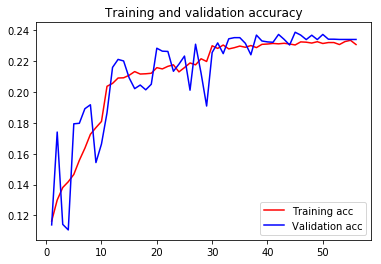

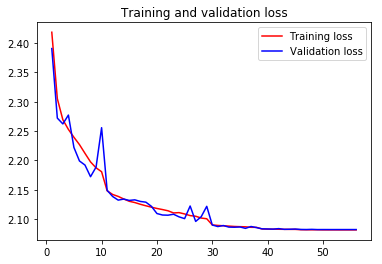

In [39]:
# plot the loss and accuracy

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()

In [43]:
model.predict(train_features_flat)

array([[8.69950727e-02, 7.29505479e-01, 1.95826758e-02, ...,
        8.48328200e-05, 5.25766052e-04, 7.72570074e-03],
       [6.63047731e-02, 9.85822827e-02, 7.28256702e-02, ...,
        2.54085392e-01, 9.18333009e-02, 7.36521706e-02],
       [7.15722144e-02, 7.37749711e-02, 8.73913541e-02, ...,
        1.51125088e-01, 1.26937523e-01, 1.05564624e-01],
       ...,
       [9.86657292e-02, 8.41808245e-02, 8.98183212e-02, ...,
        1.36570439e-01, 1.08738236e-01, 9.20271426e-02],
       [4.99483682e-02, 6.01359047e-02, 7.86911026e-02, ...,
        2.08960533e-01, 1.37869149e-01, 1.04661278e-01],
       [4.52359840e-02, 6.33942857e-02, 1.41813144e-01, ...,
        3.94409560e-02, 1.34058729e-01, 1.19788438e-01]], dtype=float32)

In [29]:
df = pd.read_csv('full_dff.csv')

In [30]:
df.drop(columns=['Unnamed: 0'], inplace=True)
df.head()

,brand,description,img-file,is_ethical,link,price
0,ahimasa collective,Ban the Bag - Black,a_co_1.jpg,1,https://cdn.shopify.com/s/files/1/0009/0924/65...,29.95
1,ahimasa collective,Ban the Bag - Olive,a_co_2.jpg,1,https://cdn.shopify.com/s/files/1/0009/0924/65...,29.95
2,ahimasa collective,Ban the Bag - Trendy A.F Black,a_co_3.jpg,1,https://cdn.shopify.com/s/files/1/0009/0924/65...,29.95
3,ahimasa collective,Ban the Bag - Trendy A.F Olive,a_co_4.jpg,1,https://cdn.shopify.com/s/files/1/0009/0924/65...,29.95
4,ahimasa collective,Ban the Bag - Trendy A.F White,a_co_5.jpg,1,https://cdn.shopify.com/s/files/1/0009/0924/65...,29.95


In [31]:
img_tensors=[]

In [32]:
for i, file in enumerate(df['img-file']):
    img_path = 'bag_images/_all/{}'.format(file)
    img = image.load_img(img_path, target_size=(224, 224))
    img_data = image.img_to_array(img)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)
    img_tensors.append([file, img_data/255., img_data])

In [9]:
export_imgdata = []
export_img255 = []
export_imgfile = []

for i in range(len(img_tensors)):
    export_imgdata.append(img_tensors[i][2])
    export_img255.append(img_tensors[i][1])
    export_imgfile.append(img_tensors[i][0])


In [10]:
len(export_imgdata)

1429

In [11]:
len(export_img255)

1429

In [12]:
np.save('preprocessed_data.npy', np.array(export_imgdata))
np.save('img_255.npy', np.array(export_img255))

In [13]:
np.save('img-file-seq.npy', np.array(export_imgfile))

In [15]:
df_imgs = pd.DataFrame(img_tensors)
df_imgs.to_csv('img_tensors.csv')

In [16]:
df_imgs.shape

(1429, 3)

In [21]:
rn50_list = []

def get_rn50_features(series):
    for i, file in enumerate(series):
        try:
            model = ResNet50(weights="fashion_mnist", include_top=False )
            model.summary()

            img_path = 'bag_images/_all/{}'.format(file)
            img = image.load_img(img_path, target_size=(224, 224))
            img_data = image.img_to_array(img)
            img_data = np.expand_dims(img_data, axis=0)
            img_data = preprocess_input(img_data)

            rn50_feature = model.predict(img_data)
            rn50_feature_np = np.array(rn50_feature)
            rn50_list.append([file, img_data/255., rn50_feature_np.flatten()])
            print('Done: {}'.format(i+1))
        except:
            print('{} not found'.format(file))

In [22]:
get_rn50_features(df['img-file'])

a_co_1.jpg not found
a_co_2.jpg not found
a_co_3.jpg not found
a_co_4.jpg not found
a_co_5.jpg not found
a_co_6.jpg not found
a_co_7.jpg not found
a_co_8.jpg not found
a_co_9.jpg not found
ia_1.png not found
ia_2.png not found
ia_3.png not found
ia_4.png not found
ia_5.png not found
ia_6.png not found
ia_7.png not found
ia_8.png not found
ia_9.png not found
ia_10.png not found
ia_11.png not found
ia_12.png not found
ia_13.png not found
ia_14.png not found
ia_15.png not found
ia_16.png not found
ia_17.png not found
ia_18.png not found
ia_19.png not found
ia_20.png not found
ia_21.png not found
ia_22.png not found
ia_23.png not found
ia_24.png not found
ia_25.png not found
ia_26.png not found
ia_27.png not found
ia_28.png not found
ia_29.png not found
ia_30.png not found
ia_31.png not found
ia_32.png not found
ia_33.png not found
ia_34.png not found
ia_35.png not found
ia_36.png not found
ia_37.png not found
ia_38.png not found
ia_39.png not found
ia_40.png not found
ia_41.png not found


In [ ]:
final_rn50_list = []

for i in range(len(rn50_list)):
    final_rn50_list.append({'img-file': rn50_list[i][0],
            'img-tensor': rn50_list[i][1],
            'rn50-features': rn50_list[i][2]})


In [ ]:
df_rn50 = pd.DataFrame(rn50_dict)
df_rn50.to_csv('df_resnet50.csv')

In [ ]:
export_imgdata
export_img255
export_imgfile

In [29]:
vgg16_list = []
vgg16_errors = []
def get_vgg16_features(data, file_series):
    leng = len(data)
    for i, d in enumerate(data):
        try:
            model = VGG16(weights='imagenet', include_top=False)

            vgg16_feature = model.predict(d)
            vgg16_feature_np = np.array(vgg16_feature)
            vgg16_list.append([file_series[i], vgg16_feature_np.flatten()])
            print('Done: {}/{}'.format((i+1), leng))
        except Exception as e:
            errors.append(file_series[i])
            print(str(e), ' OR {} not found'.format(file_series[i]))

In [ ]:
get_vgg16_features(export_imgdata, export_imgfile)

Instructions for updating:
Colocations handled automatically by placer.
Done: 1/1429
Done: 2/1429
Done: 3/1429
Done: 4/1429
Done: 5/1429
Done: 6/1429
Done: 7/1429
Done: 8/1429
Done: 9/1429
Done: 10/1429
Done: 11/1429
Done: 12/1429
Done: 13/1429
Done: 14/1429
Done: 15/1429
Done: 16/1429
Done: 17/1429
Done: 18/1429
Done: 19/1429
Done: 20/1429
Done: 21/1429
Done: 22/1429
Done: 23/1429
Done: 24/1429
Done: 25/1429
Done: 26/1429
Done: 27/1429
Done: 28/1429
Done: 29/1429
Done: 30/1429
Done: 31/1429
Done: 32/1429
Done: 33/1429
Done: 34/1429
Done: 35/1429
Done: 36/1429
Done: 37/1429
Done: 38/1429
Done: 39/1429
Done: 40/1429
Done: 41/1429
Done: 42/1429
Done: 43/1429
Done: 44/1429
Done: 45/1429
Done: 46/1429
Done: 47/1429
Done: 48/1429
Done: 49/1429
Done: 50/1429
Done: 51/1429
Done: 52/1429
Done: 53/1429
Done: 54/1429
Done: 55/1429
Done: 56/1429
Done: 57/1429
Done: 58/1429
Done: 59/1429
Done: 60/1429
Done: 61/1429
Done: 62/1429
Done: 63/1429
Done: 64/1429
Done: 65/1429
Done: 66/1429
Done: 67/1429

Done: 534/1429
Done: 535/1429
Done: 536/1429
Done: 537/1429
Done: 538/1429
Done: 539/1429
Done: 540/1429
Done: 541/1429
Done: 542/1429
Done: 543/1429
Done: 544/1429
Done: 545/1429
Done: 546/1429
Done: 547/1429
Done: 548/1429
Done: 549/1429
Done: 550/1429
Done: 551/1429
Done: 552/1429
Done: 553/1429
Done: 554/1429
Done: 555/1429
Done: 556/1429
Done: 557/1429
Done: 558/1429
Done: 559/1429
Done: 560/1429
Done: 561/1429
Done: 562/1429
Done: 563/1429
Done: 564/1429
Done: 565/1429
Done: 566/1429
Done: 567/1429
Done: 568/1429
Done: 569/1429
Done: 570/1429
Done: 571/1429
Done: 572/1429
Done: 573/1429
Done: 574/1429
Done: 575/1429
Done: 576/1429
Done: 577/1429
Done: 578/1429
Done: 579/1429
Done: 580/1429
Done: 581/1429
Done: 582/1429
Done: 583/1429
Done: 584/1429
Done: 585/1429
Done: 586/1429
Done: 587/1429
Done: 588/1429
Done: 589/1429
Done: 590/1429
Done: 591/1429
Done: 592/1429
Done: 593/1429
Done: 594/1429
Done: 595/1429
Done: 596/1429
Done: 597/1429
Done: 598/1429
Done: 599/1429
Done: 600/